In [1]:
# Price probability distribution forecaster via LSTM

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from tqdm import tqdm
import numpy as np
import pandas as pd
import math as m
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/deeplearning/models_santi"
from keras import Sequential
from keras._tf_keras.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam



Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/deeplearning/models_santi


In [43]:
def discrete_prices(prices,delta):

    return np.arange(int(min(prices)),int(max(prices))+1,delta)

# One-hot encoding price labels
def one_hot_encoding(prices,discrete_prices) -> np.array:

    one_hot_prices = []
    for price in prices:
        one_hot = np.zeros(len(discrete_prices))
        idx = np.argmin(abs(price-discrete_prices))
        one_hot[idx] = 1.0
        one_hot_prices.append(one_hot)

    return np.array(one_hot_prices)



class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y


def create_datasets(input_data,output_data, lag_in_days, forecast_horizon_in_hours, dataset_class, p_train=0.9, p_val=0.1, p_test=0):

    assert len(input_data) == len(output_data)

    hours = len(input_data)
    lag_in_hours = lag_in_days*24
    #forecast_hours = forecast_horizon_in_days*24

    num_train = int((hours-lag_in_hours-forecast_horizon_in_hours)/forecast_horizon_in_hours*p_train)
    num_val = int((hours-lag_in_hours-forecast_horizon_in_hours)/forecast_horizon_in_hours*p_val)
    num_test = int((hours-lag_in_hours-forecast_horizon_in_hours)/forecast_horizon_in_hours*p_test)


    # Creating features and labels dataset
    def create_features(input_data, output_data, lag_in_hours, hours):

        # features dataset to include prices from [t:t-14, t-1year-14:t-1year+14]. So from present to 2 weeks in past and what ocurred one_year before two weeks behind and ahead
        # for now (small dataset) prices from [t:t-14]
        inputs, outputs = [], []
        for i in range(12,hours,24): # features only given for clearing time t=12h everyday

            if i+lag_in_hours+forecast_horizon_in_hours > hours:
                break

            inputs.append(input_data[i:i+lag_in_hours,:])
            outputs.append(output_data[i+lag_in_hours:i+lag_in_hours+forecast_horizon_in_hours])

        return np.array(inputs), np.array(outputs)

    inputs, outputs = create_features(input_data,output_data, lag_in_hours, hours)
    training_set = dataset_class(inputs[:num_train],outputs[:num_train])
    val_set = dataset_class(inputs[num_train:num_train+num_val],outputs[num_train:num_train+num_val])
    test_set = dataset_class(inputs[-num_test:], outputs[-num_test:])

    return training_set, val_set, test_set


In [52]:
data_da = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/deeplearning/models_santi/data_santi/data_da.csv')
data_id = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/deeplearning/models_santi/data_santi/data_id.csv')

# retriving only prices from data (not date columns)
da_prices = data_da['DA ES']
id_prices = data_id.iloc[:,-3:]

# saving date features
month_sine = data_da['Month'].apply(lambda x: m.sin(x*2*m.pi/12))
day_sine = data_da['Day'].apply(lambda x: m.sin(x*2*m.pi/31))
hour_sine = data_da['Hour'].apply(lambda x: m.sin(x*2*m.pi/24))
date_features = pd.concat([month_sine,day_sine,hour_sine],axis=1)

# discretizing prices (in this case delta=1 so it is equal to rounding them to nearest integer)
da_discrete_prices = discrete_prices(da_prices,delta=1)
id_discrete_prices = list(id_prices.apply(lambda x: discrete_prices(x,delta=1), axis=0))

# setting DA price labels
da_prices_one_hot = one_hot_encoding(da_prices,da_discrete_prices)
id_prices_one_hot = [one_hot_encoding(id_prices[column],id_discrete_prices[i]) for i,column in enumerate(id_prices.columns)]

# setting datasets
lag_in_days = 2
forecast_horizon_in_hours = 24
input_data = np.hstack([np.array(date_features),np.array(da_prices).reshape(len(da_prices),1),np.array(id_prices)])
output_data_DA = np.array(da_prices).reshape(len(da_prices),1)
output_data_ID = np.array(id_prices.iloc[:,-1]).reshape(len(id_prices),1)
training_set_DA, val_set_DA, test_set_DA = create_datasets(input_data,output_data_DA,lag_in_days,forecast_horizon_in_hours,Dataset)
training_set_ID, val_set_ID, test_set_ID = create_datasets(input_data,output_data_ID,lag_in_days,forecast_horizon_in_hours,Dataset)
training_set_DA_diff_ID, val_set_DA_diff_ID, test_set_DA_diff_ID = create_datasets(input_data,output_data_DA-output_data_ID,lag_in_days,forecast_horizon_in_hours,Dataset)

print(len(training_set_DA),len(val_set_DA),len(test_set_DA))
print(output_data_DA.shape,output_data_ID.shape)


325 36 362
(8760, 1) (8760, 1)


In [ ]:
# Checking inputs and targets
i = 0
for inputs, targets in training_set:
    if i==0:
        print(targets.shape)
        break
    i+=1

(24, 1)


In [61]:
class LSTM_multivariate_input_multi_step_forecaster(nn.Module):
    def __init__(self, input_size,hidden_size,num_layers,dropout, past_horizon, forecast_horizon):
        super().__init__()
        self.forecast_horizon = forecast_horizon

        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,dropout=dropout,batch_first=True)
        #self.lstm_autoregressive = nn.LSTM(1,hidden_size,num_layers,dropout=dropout,batch_first=True)

        self.mlp = nn.Sequential(
            nn.Linear(hidden_size,48*3),
            nn.ReLU(),
            nn.LayerNorm(48*3),
            nn.Dropout(dropout),
            nn.Linear(48*3,48*2),
            nn.ReLU(),
            nn.LayerNorm(48*2),
            nn.Dropout(dropout),
            nn.Linear(48*2,48*2),
            nn.ReLU(),
            nn.LayerNorm(48*2),
            nn.Dropout(dropout),
            nn.Linear(48*2,forecast_horizon)
        )

    def forward(self,x):

        if torch.isnan(x).any():
          nans = torch.isnan(x).any().sum()
          raise ValueError(f"Input contains {nans} NaN values")

        lstm_out, _ = self.lstm(x)
        forecast = self.mlp(lstm_out[:,-1,:])

        return forecast.unsqueeze(-1)


# model inputs
input_size = training_set_DA.inputs.shape[2]
#input_size = 1
past_horizon = training_set_DA.inputs.shape[1]
hidden_size = 100
num_layers = 3
forecast_horizon = training_set_DA.targets.shape[1]
dropout = 0.2

model_DA = LSTM_multivariate_input_multi_step_forecaster(input_size, hidden_size,num_layers,dropout,past_horizon,forecast_horizon)
model_ID = LSTM_multivariate_input_multi_step_forecaster(input_size, hidden_size,num_layers,dropout,past_horizon,forecast_horizon)
model_DA_diff_ID = LSTM_multivariate_input_multi_step_forecaster(input_size, hidden_size,num_layers,dropout,past_horizon,forecast_horizon)

criterion = nn.MSELoss(reduction='mean')
optimizer_DA = optim.Adam(model_DA.parameters(),lr=0.001) # add momentum?
optimizer_ID = optim.Adam(model_ID.parameters(),lr=0.001)
optimizer_DA_diff_ID = optim.Adam(model_DA_diff_ID.parameters(),lr=0.001)



In [ ]:
#LSTM 1

batch_size = 100
train_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=batch_size,
    shuffle=False
)

num_epochs = 10
log_loss_list = []
for epoch in range(num_epochs):
    model.train()
    forecasts_list =[]
    targets_list = []
    for i,(inputs,targets) in enumerate(train_loader):

        #print(targets)
        #print(inputs[0,:,1]==torch.Tensor(id_prices.iloc[batch_size*i:batch_size*i+i+lag_in_days*24,0]))
        #print(targets[:,0]==da_prices.iloc[lag_in_days*24+i+12:lag_in_days*24+i+24+12])

        # forward pass
        inputs = inputs.float()
        targets = targets.float()
        targets = torch.roll(targets,-1,1)
        targets = targets[:,:-1]
        inputs = torch.nan_to_num(inputs, nan=10.0) # Hour 2039 has nan values for some reason
        targets = torch.nan_to_num(targets, nan=10.0) # idem
        inputs[:,:,3:input_size+1] = (inputs[:,:,3:input_size+1] - inputs[:,:,3:input_size+1].min()) / (inputs[:,:,3:input_size+1].max() - inputs[:,:,3:input_size+1].min()) # normalizing inputs only prices, not dates features (??)
        forecasts = model(inputs)
        forecasts = forecasts[:,:-1]
        forecasts_list.append(forecasts[:,-1,:].data.view(-1,1,1))
        targets_list.append(targets[:,-1,:].view(-1,1,1))
        loss = criterion(forecasts,targets)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if i % 10 == 0:
            #print(f'Sample [{i}/{len(train_loader)}], Loss: {loss:.4f}')
            #plt.plot(forecasts.data[-1,:,0],label='forecast')
            #plt.plot(targets[-1,:,0],label='targets')
            #plt.legend()
            #plt.show()

        #if i==0:
        #    break

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')
    plt.plot([forecast.item() for forecast in forecasts_list[0]],label='Forecasts')
    plt.plot([target.item() for target in targets_list[0]],label='Targets')
    plt.legend()
    plt.show()
    log_loss_list.append(torch.log(loss))


RuntimeError: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

In [62]:
#LSTM 2
num_epochs = 1000
batch_size = 100

# training DA model
train_loader_DA = torch.utils.data.DataLoader(
    training_set_DA,
    batch_size=batch_size,
    shuffle=False
)

model_DA.train()
for epoch in range(num_epochs):
  forecasts_list =[]
  targets_list = []
  for i,(inputs,targets) in enumerate(train_loader_DA):

        inputs = inputs.float()
        targets = targets.float()

        inputs = torch.nan_to_num(inputs, nan=10.0) # Hour 2039 has nan values for some reason
        targets = torch.nan_to_num(targets, nan=10.0) # idem
        #inputs[:,:,3:] = (inputs[:,:,3:] - inputs[:,:,3:].min()) / (inputs[:,:,3:].max() - inputs[:,:,3:].min()) # NORMALIZING WORSENS PERFORMANCE
        forecasts = model_DA(inputs)

        forecasts_list.append(forecasts.data)
        targets_list.append(targets.data)
        #print(forecasts.shape,targets.shape)
        loss = criterion(forecasts,targets)

        optimizer_DA.zero_grad()
        loss.backward()
        optimizer_DA.step()


  print(f'DA Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

# training ID model
train_loader_ID = torch.utils.data.DataLoader(
    training_set_ID,
    batch_size=batch_size,
    shuffle=False
)

model_ID.train()
for epoch in range(num_epochs):
  forecasts_list =[]
  targets_list = []
  for i,(inputs,targets) in enumerate(train_loader_ID):

        inputs = inputs.float()
        targets = targets.float()

        inputs = torch.nan_to_num(inputs, nan=10.0) # Hour 2039 has nan values for some reason
        targets = torch.nan_to_num(targets, nan=10.0) # idem
        #inputs[:,:,3:] = (inputs[:,:,3:] - inputs[:,:,3:].min()) / (inputs[:,:,3:].max() - inputs[:,:,3:].min()) # NORMALIZING WORSENS PERFORMANCE
        forecasts = model_ID(inputs)

        forecasts_list.append(forecasts.data)
        targets_list.append(targets.data)
        #print(forecasts.shape,targets.shape)
        loss = criterion(forecasts,targets)

        optimizer_ID.zero_grad()
        loss.backward()
        optimizer_ID.step()


  print(f'ID Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

#### TODO ####
# 1. Try train with forecast computed outside of the LSTM module
# 2. Try with only forecast in hour 12 of day, when bidding is submitted

DA Epoch [1/1000], Loss: 4816.4468
DA Epoch [2/1000], Loss: 4776.9551
DA Epoch [3/1000], Loss: 4734.9556
DA Epoch [4/1000], Loss: 4695.5083
DA Epoch [5/1000], Loss: 4657.9121
DA Epoch [6/1000], Loss: 4613.2383
DA Epoch [7/1000], Loss: 4564.8799
DA Epoch [8/1000], Loss: 4516.5254
DA Epoch [9/1000], Loss: 4489.7661
DA Epoch [10/1000], Loss: 4437.0078
DA Epoch [11/1000], Loss: 4396.1099
DA Epoch [12/1000], Loss: 4344.7969
DA Epoch [13/1000], Loss: 4294.4956
DA Epoch [14/1000], Loss: 4244.4258
DA Epoch [15/1000], Loss: 4200.0298
DA Epoch [16/1000], Loss: 4144.2080
DA Epoch [17/1000], Loss: 4083.7700
DA Epoch [18/1000], Loss: 4030.2229
DA Epoch [19/1000], Loss: 4019.8267
DA Epoch [20/1000], Loss: 3936.5430
DA Epoch [21/1000], Loss: 3887.0571
DA Epoch [22/1000], Loss: 3831.0024
DA Epoch [23/1000], Loss: 3792.3613
DA Epoch [24/1000], Loss: 3733.8826
DA Epoch [25/1000], Loss: 3678.3645
DA Epoch [26/1000], Loss: 3642.6838
DA Epoch [27/1000], Loss: 3578.7109
DA Epoch [28/1000], Loss: 3560.2422
D

In [66]:
train_loader_DA_diff_ID = torch.utils.data.DataLoader(
    training_set_DA_diff_ID,
    batch_size=batch_size,
    shuffle=False
)

model_DA_diff_ID.train()
for epoch in range(num_epochs):
  forecasts_list =[]
  targets_list = []
  for i,(inputs,targets) in enumerate(train_loader_DA_diff_ID):

        inputs = inputs.float()
        targets = targets.float()

        inputs = torch.nan_to_num(inputs, nan=10.0) # Hour 2039 has nan values for some reason
        targets = torch.nan_to_num(targets, nan=10.0) # idem
        #inputs[:,:,3:] = (inputs[:,:,3:] - inputs[:,:,3:].min()) / (inputs[:,:,3:].max() - inputs[:,:,3:].min()) # NORMALIZING WORSENS PERFORMANCE
        forecasts = model_DA_diff_ID(inputs)

        forecasts_list.append(forecasts.data)
        targets_list.append(targets.data)
        #print(forecasts.shape,targets.shape)
        loss = criterion(forecasts,targets)

        optimizer_DA_diff_ID.zero_grad()
        loss.backward()
        optimizer_DA_diff_ID.step()


  print(f'ID Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

ID Epoch [1/1000], Loss: 169.6228
ID Epoch [2/1000], Loss: 167.0494
ID Epoch [3/1000], Loss: 166.6427
ID Epoch [4/1000], Loss: 165.2113
ID Epoch [5/1000], Loss: 164.2321
ID Epoch [6/1000], Loss: 163.7051
ID Epoch [7/1000], Loss: 162.7429
ID Epoch [8/1000], Loss: 161.0083
ID Epoch [9/1000], Loss: 158.9673
ID Epoch [10/1000], Loss: 159.2967
ID Epoch [11/1000], Loss: 156.0644
ID Epoch [12/1000], Loss: 155.2874
ID Epoch [13/1000], Loss: 153.3709
ID Epoch [14/1000], Loss: 152.4317
ID Epoch [15/1000], Loss: 150.1172
ID Epoch [16/1000], Loss: 147.7643
ID Epoch [17/1000], Loss: 146.4609
ID Epoch [18/1000], Loss: 145.7383
ID Epoch [19/1000], Loss: 142.8141
ID Epoch [20/1000], Loss: 143.1104
ID Epoch [21/1000], Loss: 141.8910
ID Epoch [22/1000], Loss: 140.2968
ID Epoch [23/1000], Loss: 139.2168
ID Epoch [24/1000], Loss: 136.7858
ID Epoch [25/1000], Loss: 137.0838
ID Epoch [26/1000], Loss: 136.8904
ID Epoch [27/1000], Loss: 135.6438
ID Epoch [28/1000], Loss: 133.6098
ID Epoch [29/1000], Loss: 133

Mean Loss over DA val set: 762.647
Mean Loss over ID val set: 659.8611
Mean Loss over DA_diff_ID val set: 136.37224


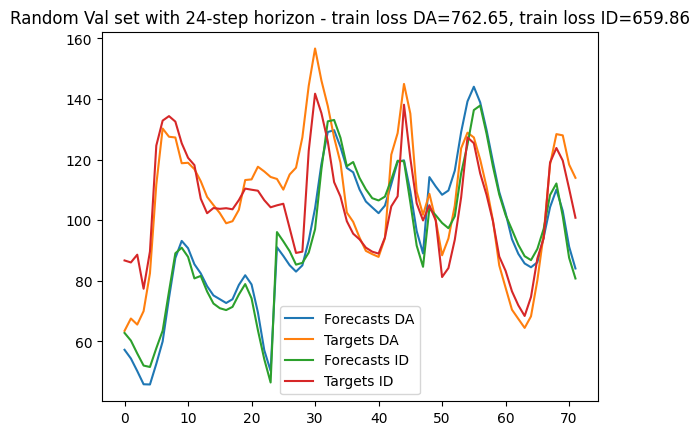

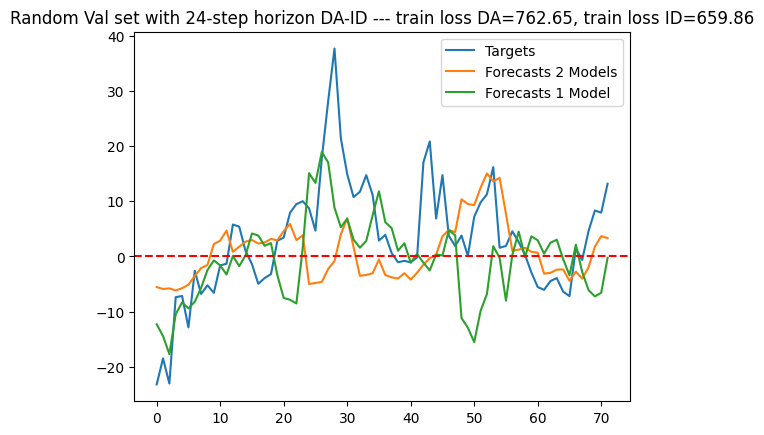

'\ntargets_list = []\nfor i,(inputs,target) in enumerate(val_loader):\n  target = target.float()\n  targets_list.append(target.item())\n\n\ninputs = torch.Tensor(val_set.inputs[0])\ninputs = inputs.unsqueeze(0)\ninputs = inputs[:,:,3].float()\ninputs = inputs.unsqueeze(-1)\nforecasts_list = []\nfor inputs,targets in val_loader:\n  forecasts_24_horizon = []\n  inputs = inputs[:,:,3].float()\n  inputs = inputs.unsqueeze(-1)\n  for h in range(24):\n      forecast = model(inputs)\n      #print(inputs.shape,forecast.shape)\n      forecasts_24_horizon.append(forecast.item())\n      inputs = torch.concatenate([inputs,forecast.data],axis=1)[:,1:,:]\n    #print(inputs.shape)\n  forecasts_list.append(forecasts_24_horizon)\n\n\n\n\nprint(len(forecasts_24_horizon),len(targets))\n\n\n\n'

In [67]:
val_loader_DA = torch.utils.data.DataLoader(
    val_set_DA,
    batch_size=1,
    shuffle=False
)
val_loader_ID = torch.utils.data.DataLoader(
    val_set_ID,
    batch_size=1,
    shuffle=False
)

val_loader_DA_diff_ID = torch.utils.data.DataLoader(
    val_set_DA_diff_ID,
    batch_size=1,
    shuffle=False
)

forecasts_DA = []
targets_DA = []
losses_DA = []
forecasts_ID = []
targets_ID = []
losses_ID = []
forecasts_DA_diff_ID = []
losses_DA_diff_ID = []
model_DA.eval()
for inputs,target in val_loader_DA:
  inputs = inputs.float()
  target = target.float()
  #inputs = inputs.unsqueeze(-1)
  forecast = model_DA(inputs)
  forecasts_DA.append(forecast.data)
  targets_DA.append(target.data)
  loss = criterion(forecast,target)
  #print(loss.data)
  losses_DA.append(loss.data)

model_ID.eval()
for inputs,target in val_loader_ID:
  inputs = inputs.float()
  target = target.float()
  #inputs = inputs.unsqueeze(-1)
  forecast = model_ID(inputs)
  forecasts_ID.append(forecast.data)
  targets_ID.append(target.data)
  loss = criterion(forecast,target)
  #print(loss.data)
  losses_ID.append(loss.data)

model_DA_diff_ID.eval()
for inputs,target in val_loader_DA_diff_ID:
  inputs = inputs.float()
  target = target.float()
  #inputs = inputs.unsqueeze(-1)
  forecast = model_DA_diff_ID(inputs)
  forecasts_DA_diff_ID.append(forecast.data)
  loss = criterion(forecast,target)
  #print(loss.data)
  losses_DA_diff_ID.append(loss.data)


print('Mean Loss over DA val set:', np.mean(losses_DA))
print('Mean Loss over ID val set:', np.mean(losses_ID))
print('Mean Loss over DA_diff_ID val set:', np.mean(losses_DA_diff_ID))

prices = {1:'DA',2:'ID'}
for i,(forecasts,targets) in enumerate(zip([forecasts_DA,forecasts_ID],[targets_DA,targets_ID])):
  plt.plot(torch.cat([forecasts[1].flatten(),forecasts[2].flatten(),forecasts[3].flatten()]),label=f'Forecasts {prices[i+1]}')
  plt.plot(torch.cat([targets[1].flatten(),targets[2].flatten(),targets[3].flatten()]),label=f'Targets {prices[i+1]}')

plt.title(f'Random Val set with 24-step horizon - train loss DA={np.mean(losses_DA):.2f}, train loss ID={np.mean(losses_ID):.2f}')
plt.legend()
plt.show()

#labels = {1:'Targets',2:'Forecasts 2 Models'}
for i,(DA,ID) in enumerate(zip([targets_DA,forecasts_DA],[targets_ID,forecasts_ID])):
    plt.plot(torch.cat([DA[1].flatten()-ID[1].flatten(),DA[2].flatten()-ID[2].flatten(),DA[3].flatten()-ID[3].flatten()]),label=f'{labels[i+1]}')

plt.plot(torch.cat([forecasts_DA_diff_ID[1].flatten(),forecasts_DA_diff_ID[2].flatten(),forecasts_DA_diff_ID[3].flatten()]),label='Forecasts 1 Model')

plt.axhline(0,linestyle='--',color='r')
plt.title(f'Random Val set with 24-step horizon DA-ID --- train loss DA={np.mean(losses_DA):.2f}, train loss ID={np.mean(losses_ID):.2f}')
plt.legend()
plt.show()


'''
targets_list = []
for i,(inputs,target) in enumerate(val_loader):
  target = target.float()
  targets_list.append(target.item())


inputs = torch.Tensor(val_set.inputs[0])
inputs = inputs.unsqueeze(0)
inputs = inputs[:,:,3].float()
inputs = inputs.unsqueeze(-1)
forecasts_list = []
for inputs,targets in val_loader:
  forecasts_24_horizon = []
  inputs = inputs[:,:,3].float()
  inputs = inputs.unsqueeze(-1)
  for h in range(24):
      forecast = model(inputs)
      #print(inputs.shape,forecast.shape)
      forecasts_24_horizon.append(forecast.item())
      inputs = torch.concatenate([inputs,forecast.data],axis=1)[:,1:,:]
    #print(inputs.shape)
  forecasts_list.append(forecasts_24_horizon)




print(len(forecasts_24_horizon),len(targets))



'''


Accuracies of 1 model --> Sign: 0.6041666666666666 Abs Values of matches: 14.0109625 Abs Values of mismatches: 20.85831
Average and std price paid for mismatch: 13.786759 15.010958 Average and std price received for match: 17.786907 16.91645
864


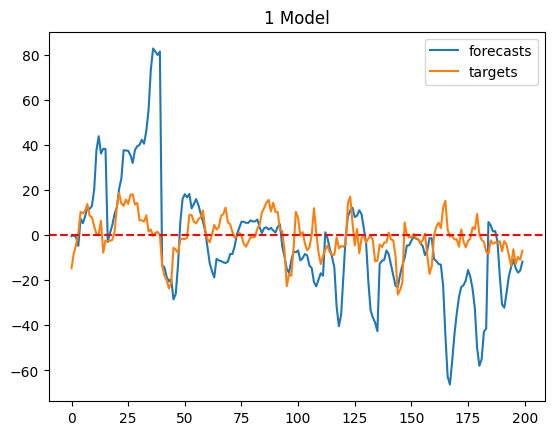

Accuracies of 2 model --> Sign: 0.5509259259259259 Abs Values of matches: 6.3393393 Abs Values of mismatches: 12.044043
Average and std price paid for mismatch: 5.0770316 4.690777 Average and std price received for match: 6.0536904 5.3796473
864


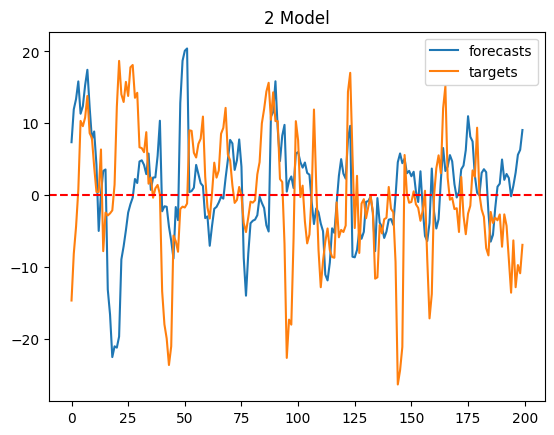

In [119]:
# defining accuracy as diff forecasts having same sign as diff targets:
def accuracy(forecasts,targets):
  forecasts = forecasts.numpy()
  targets = targets.numpy()
  temp = forecasts*targets/np.abs(forecasts*targets)

  temp[temp==-1]=0 # masking the -1 with 0 because the correct ones are only the value 1
  accuracy_of_sign  = np.sum(temp)/len(forecasts)

  matches = temp==1
  mismatches = temp==0
  diff_values_matches = np.abs(targets[matches] - forecasts[matches])
  diff_values_mismatches = np.abs(targets[mismatches] - forecasts[mismatches])
  avg_price_paid_mismatches = np.mean(np.abs(forecasts[mismatches])) # forecasts is the diff between the DA and ID which is what you pay if you don't forecast correctly the sign difference (mismatch)
  avg_price_recieved_matches = np.mean(np.abs(forecasts[matches])) # forecasts is the diff between the DA and ID which is what you get paid if you do forecast correctly the sign difference (match)
  std_price_paid_mismatches = np.std(np.abs(forecasts[mismatches]))
  std_price_recieved_matches = np.std(np.abs(forecasts[matches]))

  return accuracy_of_sign, np.mean(diff_values_matches), np.mean(diff_values_mismatches), avg_price_paid_mismatches,avg_price_recieved_matches, std_price_paid_mismatches, std_price_recieved_matches

targets = torch.cat([DA_targets.flatten()-ID_targets.flatten() for DA_targets,ID_targets in zip(targets_DA,targets_ID)])
forecasts_2_models = [DA_forecasts-ID_forecasts for DA_forecasts,ID_forecasts in zip(forecasts_DA,forecasts_ID)]
for i,forecast in enumerate([forecasts_2_models,forecasts_DA_diff_ID]):

  forecasts = torch.cat([forecasts.flatten() for forecasts in forecast])


  accuracy_1_model_signs, accuracy_1_model_matches, accuracy_1_model_mismatches, avg_price_paid_mismatches,avg_price_recieved_matches, std_price_paid_mismatches, std_price_recieved_matches = accuracy(forecasts,targets)
  print(f'Accuracies of {i+1} model -->','Sign:', accuracy_1_model_signs, 'Abs Values of matches:',accuracy_1_model_matches, 'Abs Values of mismatches:',accuracy_1_model_mismatches)
  print('Average and std price paid for mismatch:',avg_price_paid_mismatches,std_price_paid_mismatches,'Average and std price received for match:',avg_price_recieved_matches,std_price_recieved_matches)
  print(len(forecasts))

  plt.plot(forecasts[200:400],label='forecasts')
  plt.plot(targets[200:400],label='targets')
  plt.axhline(0,linestyle='--',color='r')
  plt.title(f'{i+1} Model')
  plt.legend()
  plt.show()

871


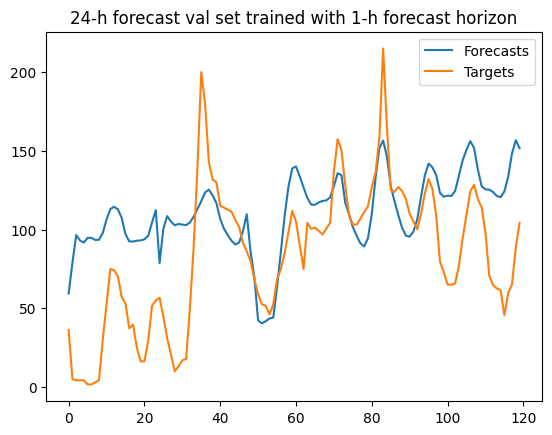

In [ ]:
print(len(targets_list))
plt.plot([value for forecasts in [forecasts_list[0],forecasts_list[24],forecasts_list[48],forecasts_list[72],forecasts_list[24*4]] for value in forecasts],label='Forecasts')
plt.plot(targets_list[:24*5],label='Targets')
plt.title('24-h forecast val set trained with 1-h forecast horizon')
plt.legend()
plt.show()

In [ ]:
print(training_set.inputs[0].shape)
print(training_set.targets[0].shape)

# unpacking lstm_params
units, epochs, verbose = 10,500,0

class LossPrinter(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {logs['loss']}")

loss_printer = LossPrinter()


inputs = np.nan_to_num(training_set.inputs, nan=10.0) # Hour 2039 has nan values for some reason
targets = np.nan_to_num(training_set.targets, nan=10.0) # idem
inputs = np.expand_dims(inputs[:,:,3], axis=2)
print(inputs.shape,targets.shape)
# training the model
model = Sequential()
model.add(LSTM(units,return_sequences=True))
model.add(LSTM(units))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
model.fit(inputs, targets, epochs=epochs, batch_size=100, verbose=verbose,callbacks=[loss_printer])

(48, 7)
(1, 1)
(6969, 48, 1) (6969, 1, 1)
Epoch 1/500, Loss: 10016.693359375
Epoch 2/500, Loss: 9687.5625
Epoch 3/500, Loss: 9369.2802734375
Epoch 4/500, Loss: 9160.9765625
Epoch 5/500, Loss: 8993.64453125
Epoch 6/500, Loss: 8842.71875
Epoch 7/500, Loss: 8699.1533203125
Epoch 8/500, Loss: 8560.904296875
Epoch 9/500, Loss: 8426.8134765625
Epoch 10/500, Loss: 8296.181640625
Epoch 11/500, Loss: 8168.52099609375
Epoch 12/500, Loss: 8043.5166015625
Epoch 13/500, Loss: 7920.82080078125
Epoch 14/500, Loss: 7800.5166015625
Epoch 15/500, Loss: 7682.19921875
Epoch 16/500, Loss: 7565.939453125
Epoch 17/500, Loss: 7451.55712890625
Epoch 18/500, Loss: 7339.01513671875
Epoch 19/500, Loss: 7228.0498046875
Epoch 20/500, Loss: 7118.87548828125
Epoch 21/500, Loss: 7011.2529296875
Epoch 22/500, Loss: 6905.2099609375
Epoch 23/500, Loss: 6800.6845703125
Epoch 24/500, Loss: 6697.68798828125
Epoch 25/500, Loss: 6596.04345703125
Epoch 26/500, Loss: 6495.98291015625
Epoch 27/500, Loss: 6397.07275390625
Epoch 2

In [ ]:
forecasts = model.predict(test_set.inputs)
print(forecasts.shape,test_set.inputs.shape)
plt.plot(forecasts[:100,0],label='predictions')
plt.plot(test_set.targets[:100][:,0,0],label='targets')
plt.legend()
plt.show()

ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 7 and 1 for '{{node sequential_28_1/lstm_36_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_28_1/lstm_36_1/strided_slice_1, sequential_28_1/lstm_36_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [32,7], [1,40].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(32, 7), dtype=float32)
  • states=('tf.Tensor(shape=(32, 10), dtype=float32)', 'tf.Tensor(shape=(32, 10), dtype=float32)')
  • training=False

(871, 48, 7)
(1, 48, 7) (1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[97.47032928466797, 76.34114837646484, 90.1637191772461, 

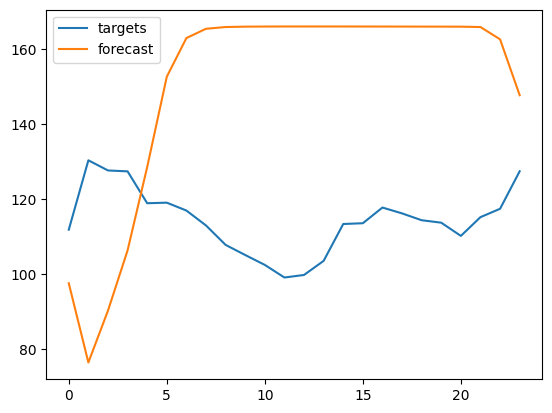

In [ ]:
print(test_set.inputs.shape)
inputs,targets = test_set[0]
inputs = np.expand_dims(inputs, axis=0)
#targets = np.expand_dims(targets, axis=0)
print(inputs.shape,targets.shape)
targets_list = []
forcasts_list = []
forecast_horizon = 24


for i in range(forecast_horizon):
  _,targets = test_set[i]
  forecast = model.predict(inputs)
  #print(forecast.item())
  forecasts_list.append(forecast.item())
  targets_list.append(targets.item())
  forecast_inputs = np.zeros((1,1,7))
  #forecast_inputs[:,:,3] = forecast
  #print(forecast.shape)
  inputs_autoreg = np.concatenate([inputs,forecast],axis=1)[:,1:,:]
  inputs = inputs_autoreg

print(forecasts_list)
plt.plot(targets_list,label='targets')
plt.plot(forecasts_list,label='forecast')
plt.legend()
plt.show()


In [ ]:
# LSTM 3

class MultiInputLSTMClassifier(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_classes: int,
        forecast_horizon: int,
        num_lstm_layers: int = 2,
        dropout: float = 0.2,
        bidirectional: bool = True
    ):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.forecast_horizon = forecast_horizon
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0,
            bidirectional=bidirectional
        )

        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size * self.num_directions,
            num_heads=4,
            dropout=dropout,
            batch_first=True
        )

        self.layer_norm = nn.LayerNorm(hidden_size * self.num_directions)

        # Corrected decoder input size calculation
        decoder_input_size = self.hidden_size * self.num_directions
        self.decoder = nn.Sequential(
            nn.Linear(decoder_input_size, hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.classifiers = nn.ModuleList([
            nn.Linear(hidden_size, num_classes)
            for _ in range(forecast_horizon)
        ])

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(0)  # Add batch dimension [1, 336, 4]

        output, _ = self.lstm(x)  # output shape: [batch, 336, hidden_size * num_directions]

        attended, _ = self.attention(output, output, output)
        attended = self.layer_norm(attended + output)

        last_hidden = attended[:, -1, :]  # [batch, hidden_size * num_directions]

        decoded = self.decoder(last_hidden)  # [batch, hidden_size]

        predictions = []
        for classifier in self.classifiers:
            step_pred = classifier(decoded)  # [batch, num_classes]
            step_pred = F.softmax(step_pred, dim=-1)  # Apply softmax
            predictions.append(step_pred)

        predictions = torch.stack(predictions, dim=1)  # [batch, 24, num_classes]

        return predictions

def train_step(model, optimizer, criterion, inputs, targets_one_hot):
    """
    Args:
        inputs: [336, 4]
        targets_one_hot: [24, num_classes]
    """
    optimizer.zero_grad()

    outputs = model(inputs)  # [1, 24, num_classes]
    outputs = outputs.squeeze(0)  # [24, num_classes]

    # Compute loss using one-hot encoded targets
    loss = 0
    for step in range(outputs.shape[0]):
        step_pred = outputs[step]  # [num_classes]
        step_target = targets_one_hot[step]  # [num_classes]
        # Use NLL loss with log_softmax
        step_loss = -(step_target * torch.log(step_pred + 1e-10)).sum()
        loss += step_loss

    loss.backward()
    optimizer.step()
    return loss.item()


# Setup
model = MultiInputLSTMClassifier(
    input_size=4,  # 4 features
    hidden_size=64,
    num_classes=len(da_discrete_prices),
    forecast_horizon=24,
    num_lstm_layers=2
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 2
for epoch in range(num_epochs):
    for i, (inputs, target) in enumerate(training_set):
        inputs = torch.Tensor(inputs)  # [336, 4]
        labels_one_hot = one_hot_encoding(target, da_discrete_prices)  # [24, num_classes]
        labels_one_hot_tensor = torch.Tensor(labels_one_hot)

        #loss = train_step(model, optimizer, criterion, inputs, labels_one_hot_tensor)

        if i % 10 == 0:
            print(f'Sample [{i}/{len(training_set)}], Loss: {loss:.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')



Sample [0/41], Loss: 9514.2656
Sample [10/41], Loss: 9514.2656
Sample [20/41], Loss: 9514.2656
Sample [30/41], Loss: 9514.2656
Sample [40/41], Loss: 9514.2656
Epoch [1/2], Loss: 9514.2656
Sample [0/41], Loss: 9514.2656
Sample [10/41], Loss: 9514.2656
Sample [20/41], Loss: 9514.2656
Sample [30/41], Loss: 9514.2656
Sample [40/41], Loss: 9514.2656
Epoch [2/2], Loss: 9514.2656


In [ ]:
# Setting LSTM classifier
# Define LSTM classifier model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, 12:36, :])
        out = out.view(-1, self.hidden_size)  # shape: (batch_size * 24, hidden_size)
        out = self.fc(out)  # shape: (batch_size * 24, output_size)
        out = out.view(x.size(0), 24, -1)
        return out

# num of inputs
num_input_features = input_data.shape[1]

#input_size = training_set.inputs.shape[1]
model = LSTMClassifier(num_input_features, len(da_discrete_prices), 2, len(da_discrete_prices))

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
batch_size = 1
num_epochs = 5
for epoch in range(num_epochs):

    for i,(inputs,target) in enumerate(training_set):

        # Should inputs be one-hot encoded as well??!!
        #inputs_one_hot_da = one_hot_encoding(inputs[:lag_in_days*24*1],da_discrete_prices)
        #inputs_one_hot_id_max = one_hot_encoding(inputs[14*24*1:14*24*2],id_discrete_prices[0])
        #inputs_one_hot_id_min = one_hot_encoding(inputs[14*24*2:14*24*3],id_discrete_prices[1])
        #inputs_one_hot_id_avg = one_hot_encoding(inputs[14*24*3:14*24*4],id_discrete_prices[2])


        labels_one_hot_da = one_hot_encoding(target[:24], da_discrete_prices)
        labels_one_hot_da_tensor = torch.Tensor(labels_one_hot_da).unsqueeze(0)
        inputs_reshaped = inputs.reshape(1, lag_in_days*24, num_input_features)
        inputs_tensor = torch.Tensor(inputs_reshaped)

        optimizer.zero_grad()
        outputs = model(inputs_tensor)
        loss = criterion(outputs,labels_one_hot_da_tensor)
        loss.backward()
        optimizer.step()

        if i%10==0:
            print(f'Sample [{i}/{training_set.inputs.shape[0]}], Loss: {loss.item()}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')








Sample [0/6739], Loss: 0.3449981212615967
Sample [10/6739], Loss: 0.345223993062973
Sample [20/6739], Loss: 0.3441427946090698
Sample [30/6739], Loss: 0.345664918422699
Sample [40/6739], Loss: 0.34552523493766785
Sample [50/6739], Loss: 0.34575024247169495
Sample [60/6739], Loss: 0.3451893627643585
Sample [70/6739], Loss: 0.34449443221092224
Sample [80/6739], Loss: 0.3454661965370178
Sample [90/6739], Loss: 0.34381213784217834
Sample [100/6739], Loss: 0.3466441333293915
Sample [110/6739], Loss: 0.3442423641681671
Sample [120/6739], Loss: 0.3342514932155609
Sample [130/6739], Loss: 0.34682929515838623
Sample [140/6739], Loss: 0.33041051030158997
Sample [150/6739], Loss: 0.33303022384643555
Sample [160/6739], Loss: 0.3438871204853058
Sample [170/6739], Loss: 0.3318692743778229
Sample [180/6739], Loss: 0.34575703740119934
Sample [190/6739], Loss: 0.34351155161857605
Sample [200/6739], Loss: 0.34963157773017883
Sample [210/6739], Loss: 0.3453594446182251
Sample [220/6739], Loss: 0.34513026

KeyboardInterrupt: 